In [326]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten,Bidirectional,SimpleRNN
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from numpy import array 

%matplotlib inline 

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df.apply(lambda x: x.nunique())

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
dtype: int64

In [6]:
df.apply(lambda x: x.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [417]:
train_df=df[(df['Store']==3)&(df['Dept']==4)]

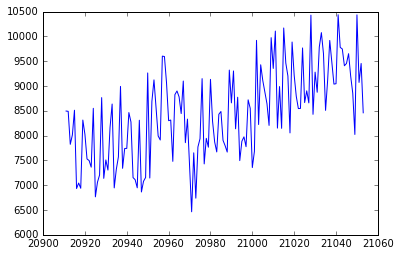

In [418]:
plt.plot(train_df['Weekly_Sales'])

In [419]:
train_df.shape

(143, 5)

In [420]:
train_df.iloc[0:14]

,Store,Dept,Date,Weekly_Sales,IsHoliday
20911,3,4,2010-02-05,8495.10,False
20912,3,4,2010-02-12,8489.46,True
20913,3,4,2010-02-19,7824.13,False
20914,3,4,2010-02-26,8012.43,False
20915,3,4,2010-03-05,8511.73,False
20916,3,4,2010-03-12,6932.93,False
20917,3,4,2010-03-19,7043.63,False
20918,3,4,2010-03-26,6938.17,False
20919,3,4,2010-04-02,8313.44,False
20920,3,4,2010-04-09,8025.03,False


In [421]:
train_df=train_df.iloc[:,2:4]



In [424]:
train_df.head()

,Date,Weekly_Sales
20911,2010-02-05,0.511268
20912,2010-02-12,0.509848
20913,2010-02-19,0.342361
20914,2010-02-26,0.389763
20915,2010-03-05,0.515454


In [423]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
train_df['Weekly_Sales']=x_scaler.fit_transform(train_df.Weekly_Sales.values)

c:\users\arpan\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\arpan\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [425]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[:105], data[106:141]
	# restructure into windows of weekly data
	train = np.array(np.split(train, len(train)/7))
	test = np.array(np.split(test, len(test)/7))
	return train, test

In [426]:
train,test=split_dataset(train_df.iloc[:,1].values)

In [427]:
train

array([[0.51126763, 0.50984785, 0.34236137, 0.38976297, 0.51545398,
        0.11801563, 0.14588263],
       [0.11933472, 0.46553755, 0.39293482, 0.26807202, 0.26007441,
        0.2264729 , 0.5251231 ],
       [0.07580731, 0.15033078, 0.1867341 , 0.57943481, 0.16963126,
        0.26309019, 0.2116105 ],
       [0.42767166, 0.54686037, 0.12116986, 0.21547462, 0.27851144,
        0.63631169, 0.22054203],
       [0.32127609, 0.32166628, 0.50364763, 0.45567208, 0.17360363,
        0.16287974, 0.12162298],
       [0.4646741 , 0.10052764, 0.15466816, 0.17424052, 0.70463997,
        0.17132543, 0.55969882],
       [0.6694198 , 0.52368569, 0.38468548, 0.3643403 , 0.7900006 ,
        0.78798673, 0.6536436 ],
       [0.46240094, 0.46554762, 0.25586541, 0.5946446 , 0.61309674,
        0.58329138, 0.49835114],
       [0.66354936, 0.35073909, 0.47043127, 0.23809044, 0.        ,
        0.29925436, 0.06909355],
       [0.32892127, 0.37090806, 0.67574841, 0.2429464 , 0.37267523,
        0.3277935 , 0.6

In [428]:
train.shape

(15, 7)

In [210]:
#from sklearn.preprocessing import MinMaxScaler
#x_scaler = MinMaxScaler()
#train=x_scaler.fit_transform(train)
#test=x_scaler.transform(test)




In [429]:
train=train.reshape(np.shape(train)[0],np.shape(train)[1],1)

test=test.reshape(np.shape(test)[0],np.shape(test)[1],1)

In [430]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [431]:
np.shape(train)

(15, 7, 1)

In [432]:
n_input = 7

train_x, train_y = to_supervised(train, n_input)
train_y=train_y[:,0]

In [433]:
train_x

array([[[0.51126763],
        [0.50984785],
        [0.34236137],
        [0.38976297],
        [0.51545398],
        [0.11801563],
        [0.14588263]],

       [[0.50984785],
        [0.34236137],
        [0.38976297],
        [0.51545398],
        [0.11801563],
        [0.14588263],
        [0.11933472]],

       [[0.34236137],
        [0.38976297],
        [0.51545398],
        [0.11801563],
        [0.14588263],
        [0.11933472],
        [0.46553755]],

       [[0.38976297],
        [0.51545398],
        [0.11801563],
        [0.14588263],
        [0.11933472],
        [0.46553755],
        [0.39293482]],

       [[0.51545398],
        [0.11801563],
        [0.14588263],
        [0.11933472],
        [0.46553755],
        [0.39293482],
        [0.26807202]],

       [[0.11801563],
        [0.14588263],
        [0.11933472],
        [0.46553755],
        [0.39293482],
        [0.26807202],
        [0.26007441]],

       [[0.14588263],
        [0.11933472],
        [0.46553755]

In [434]:
np.shape(train_x)

(92, 7, 1)

In [435]:
train_x[0,:,:]

array([[0.51126763],
       [0.50984785],
       [0.34236137],
       [0.38976297],
       [0.51545398],
       [0.11801563],
       [0.14588263]])

In [436]:
train_y[0]

0.1193347161945808

In [530]:
MAX_LENGTH=7
vocab_size=100
inputs = Input(shape=(MAX_LENGTH,1))
#x = Embedding(input_dim=vocab_size,output_dim=128,input_length=MAX_LENGTH)(inputs)
#x = Flatten()(embedding_layer)
x=LSTM(63,activation='relu',return_sequences=False,input_shape=(7,1))(inputs)
#x=LSTM(21,activation='relu',return_sequences=False,input_shape=(7,63))(x)

#x=Dropout(0.5)(x)
#x=SimpleRNN(32,activation='relu',input_shape = (7,1),return_sequences=True)(inputs)
#x = Flatten()(x)
#x = Flatten()(x)
x = Dense(7, activation='relu')(x)

predictions = Dense(1, activation='relu')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',loss='mean_squared_error')

model.summary()
filepath="weights_lstm_2.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit([train_x], batch_size=1, y=train_y, verbose=1, validation_split=0.5, 
          shuffle=False, epochs=50, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       (None, 7, 1)              0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 63)                16380     
_________________________________________________________________
dense_113 (Dense)            (None, 7)                 448       
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 8         
Total params: 16,836
Trainable params: 16,836
Non-trainable params: 0
_________________________________________________________________
Train on 46 samples, validate on 46 samples
Epoch 1/50
45/46 [============================>.] - ETA: 0s - loss: 0.0544
Epoch 00001: loss improved from inf to 0.05327, saving model to weights_lstm_2.hdf5
46/46 [==============================] - 17s 380ms/step - loss: 0.0

In [531]:
n_input = 7

test_x, test_y = to_supervised(test, n_input)
test_y=test_y[:,0]


In [532]:
np.shape(test_y)

(22,)

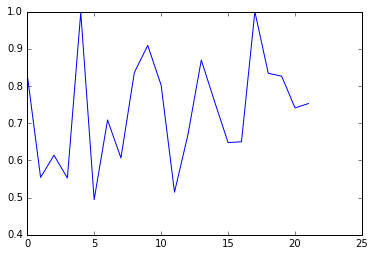

In [533]:
plt.plot(test_y)

In [534]:
predicted=model.predict(test_x)

In [535]:
predicted=x_scaler.inverse_transform(predicted.reshape(22,-1))
test_y=x_scaler.inverse_transform(test_y.reshape(22,-1))

In [536]:
#y_scaler=MinMaxScaler()
#y_scaler.min_,y_scaler.scale_=x_scaler.min_[0],x_scaler.scale_[0]
#predicted=y_scaler.inverse_transform(predicted.reshape(22,-1))
#test_y=y_scaler.inverse_transform(test_y.reshape(22,-1))

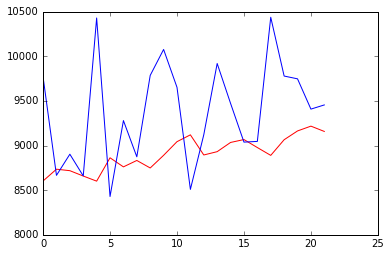

In [537]:
plt.plot(predicted,color='r')
plt.plot(test_y,color='b')

In [538]:
np.sqrt(np.mean((predicted-test_y)**2))

768.9851238658536

In [397]:
np.round(test_y)

array([[ 9767.],
       [ 9087.],
       [ 8752.],
       [ 9012.],
       [10819.],
       [ 8569.],
       [ 9142.],
       [ 8874.],
       [10530.],
       [ 9943.],
       [10495.],
       [ 8856.],
       [ 9403.],
       [ 9740.],
       [ 9472.],
       [ 9567.],
       [ 8897.],
       [11668.],
       [10154.],
       [10159.],
       [ 9262.],
       [ 9455.]])

In [398]:
np.round(predicted)

array([[8442.],
       [8483.],
       [8508.],
       [8457.],
       [8430.],
       [8572.],
       [8563.],
       [8561.],
       [8510.],
       [8612.],
       [8697.],
       [8796.],
       [8722.],
       [8718.],
       [8729.],
       [8729.],
       [8690.],
       [8623.],
       [8757.],
       [8868.],
       [8917.],
       [8873.]], dtype=float32)

In [255]:
test_x[0]

array([[0.75920531],
       [0.47798926],
       [0.93019027],
       [0.95973864],
       [0.7417557 ],
       [0.60579315],
       [0.52728651]])

In [256]:
test_y

array([[ 9767.34      ],
       [ 9087.48344821],
       [ 8751.82703411],
       [ 9012.10078539],
       [10819.4681516 ],
       [ 8568.94363629],
       [ 9141.92117648],
       [ 8873.67      ],
       [10530.04888615],
       [ 9942.79083011],
       [10494.88895949],
       [ 8855.98271781],
       [ 9403.37205954],
       [ 9739.85371498],
       [ 9472.05      ],
       [ 9567.35078865],
       [ 8897.33660892],
       [11668.05049245],
       [10154.36137797],
       [10158.5757257 ],
       [ 9262.00530653],
       [ 9454.64      ]])

In [400]:
np.shape(train)

(15, 7, 1)